In [4]:
import wrds
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import os
import sys
from pathlib import Path

# add the src directory to the path in order to import config
current_directory = Path.cwd()
src_path = current_directory.parent / "src"
sys.path.insert(0, str(src_path))

import load_option_data_01 as l1
import filter_option_data_01 as f1
import bsm_pricer as bsm
import config
WRDS_USERNAME = Path(config.WRDS_USERNAME)
DATA_DIR = Path(config.DATA_DIR)

In [3]:
def pull_option_price(wrds_username, year=2012): 
	db = wrds.Connection(wrds_username=wrds_username)

	sql_query = f"""
					SELECT 
						*
					FROM
						optionm_all.opprcd{year} AS a
					WHERE
						a.secid=108105;
				"""
		
	optm_df = db.raw_sql(sql_query, date_cols = ["date"])

	db.close()

	return optm_df

def pull_all_option_price(wrds_username, last_year=2012): 
	db = wrds.Connection(wrds_username=wrds_username)

	optm_df = []

	for year in range(1996,last_year+1):
		sql_query = f"""
						SELECT 
							a.date, a.exdate, a.cp_flag, a.strike_price
						FROM
							optionm_all.opprcd{year} AS a
						WHERE
							a.secid=108105;
					"""
		
		optm = db.raw_sql(sql_query, date_cols = ["date"])

		optm_df.append(optm)
		
	db.close()

	optm_df = pd.concat(optm_df)
	
	return optm_df


def pull_all_req_data(wrds_username, start_year=1996, end_year=2012): 
	db = wrds.Connection(wrds_username=wrds_username)

	optm_df = []

	for year in range(start_year, end_year+1):
		sql_query = f"""
						SELECT 
							a.date, a.exdate, a.cp_flag, a.strike_price, a.best_bid, a.best_offer,a.volume,
							b.open, b.close, a.impl_volatility, c.tb_m3
						FROM
							optionm_all.opprcd{year} AS a
						JOIN 
							optionm_all.secprd{year} AS b ON a.date = b.date AND a.secid = b.secid
						JOIN 
							frb_all.rates_daily AS c ON c.date = a.date 
						WHERE
							a.secid=108105 AND a.date <= '2012-01-31';
					"""
		
		optm = db.raw_sql(sql_query, date_cols = ["date"])

		optm_df.append(optm)
		
	db.close()

	optm_df = pd.concat(optm_df)
	
	return optm_df

def pull_Opt_Sec_info_WRDS(wrds_username = WRDS_USERNAME, start = '1996-01-04', end = '2012-01-31'): 
	#https://wrds-www.wharton.upenn.edu/pages/get-data/option-suite-wrds/us-option-level-output/
	sql_query = f"""
		SELECT  
			a.*, c.tb_m3
		FROM
			beta.wrdsapps_optionsig  AS a
		JOIN 
			frb_all.rates_daily AS c ON c.date = a.date 
		WHERE
			(a.secid = 108105) 
		AND 
			(a.date <= \'{end}\') 
		AND 
			(a.date >= \'{start}\')
		LIMIT 1000
	""" 
	#LIMIT 1000
	db = wrds.Connection(wrds_username=wrds_username)
	optm = db.raw_sql(sql_query, date_cols = ["date", "exdate"])
	db.close()
	return optm

In [10]:
# optm_df = pd.read_parquet(DATA_DIR / "pulled" / "data_1996-01_2012-01.parquet")
optm_df = pd.read_parquet(DATA_DIR / "pulled" / "data_2012-02_2023-12.parquet")

In [11]:
optm_df['date'].max()

Timestamp('2020-03-25 00:00:00')

<Axes: xlabel='date'>

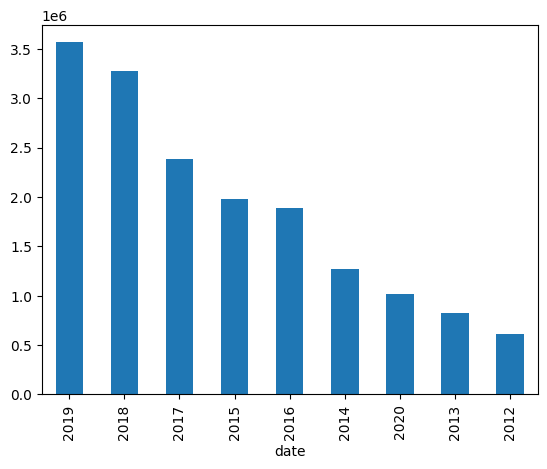

In [15]:
optm_df['date'].dt.year.value_counts().plot(kind='bar')

In [10]:
print(optm_df.shape)
print(optm_df['cp_flag'].value_counts().to_dict())

(3410580, 14)
{'P': 1706360, 'C': 1704220}


In [5]:
optm_df['option_price'] = (optm_df['best_bid'] + optm_df['best_offer'])/2
optm_df['index_price'] = (optm_df['open'] + optm_df['close'])/2

### Level 1 filters

#### Identical Filter:
The OptionMetrics data set contain duplicate observations,
defined as two or more quotes with identical option type, strike, expiration
date, and price. In each such case, we eliminate all but one of the quotes.

In [5]:
# Assuming 'df' is your DataFrame

def delete_identical_filter(df):
    columns_to_check = ['cp_flag', 'strike_price','date', 'exdate', 'best_offer']

    # Drop duplicates based on specified columns
    df = df.drop_duplicates(subset=columns_to_check, keep='first')

    return df

In [3]:
optm_l1_df = pd.read_parquet(DATA_DIR / "pulled" / 'data_199601_201201_L1filter.parquet')
optm_l1_df.shape

(3138492, 16)

#### Identical Except Price Filter:
There are a few sets of quotes with identical
terms (type, strike, and maturity) but different prices. When this occurs, we
keep the quote whose T-bill-based implied volatility is closest to that of its
moneyness neighbors, and delete the others.

NEXT STEPS - determine moneyness neighbors >> only 18 duplicates so 9 deleted versus 11 in paper

In [198]:
def delete_identical_xprice_filter(df):
    columns_to_check = ['cp_flag', 'strike_price','date', 'exdate']

    # Drop duplicates based on specified columns
    df = df.drop_duplicates(subset=columns_to_check, keep='first')

    return df

In [199]:
columns_to_check = ['cp_flag', 'strike_price','date', 'exdate']

identical_df = optm_l1_df[optm_l1_df.duplicated(columns_to_check,keep=False)].sort_values(columns_to_check)

identical_df.shape

(20, 16)

In [200]:
identical_df = optm_l1_df[optm_l1_df.duplicated(columns_to_check,keep='first')].sort_values(columns_to_check)
identical_df.shape

(10, 16)

In [201]:
optm_l1_df = delete_identical_xprice_filter(optm_l1_df)
print(optm_l1_df.shape)

(3410570, 16)


In [202]:
def delete_zero_bid(df):
    df=df.loc[df['best_bid'] > 0]
    return df

In [203]:
optm_l1_df = delete_zero_bid(optm_l1_df)

In [204]:
optm_df.shape[0] - optm_l1_df.shape[0]

272088

In [205]:
optm_l1_df.shape[0]

3138492

### Level 2 filters
* “Days to Maturity <7 or >180” Filter
* “IV<5% or >100%” Filter
* “Moneyness <0.8 or >1.2” Filter
* “Implied Interest Rate <0” Filter

In [21]:
def clear_module_cache(module_name):
    if module_name in sys.modules:
        del sys.modules[module_name]

In [222]:
clear_module_cache('filter_option_data_02')

In [7]:
import filter_option_data_02 as f2

In [8]:
# optm_l2_df = pd.read_parquet(DATA_DIR / 'pulled' / 'data_199601_201201_L2filter.parquet')

In [10]:
optm_l2_df = optm_l1_df.copy()
optm_l2_df['tb_m3'].ffill(inplace=True)

In [13]:
optm_l2_df = f2.filter_time_to_maturity(optm_l2_df)
optm_l2_df.shape

(1840763, 18)

In [31]:
optm_l2_df.shape[0] - optm_l2_df.loc[((optm_l2_df['impl_volatility']>=0.05) & (optm_l2_df['impl_volatility']<=1)) | (optm_l2_df['impl_volatility'].isna())].shape[0]

16432

In [55]:
test = optm_l2_df.loc[1]
test

secid                              108105.0
date                    1996-01-04 00:00:00
open                                 621.32
close                                 617.7
cp_flag                                   C
exdate                  1996-06-22 00:00:00
impl_volatility                    0.125173
tb_m3                                0.0504
volume                                  0.0
open_interest                         195.0
best_bid                               38.5
best_offer                             39.5
strike_price                          595.0
contract_size                         100.0
sec_price                             617.7
mnyns                              0.963251
time_to_maturity                        170
time_to_matility_yrs               0.465753
iv_guess                           0.125173
Name: 1, dtype: object

In [23]:
clear_module_cache('bsm_pricer')
import bsm_pricer as bsm

In [46]:
optm_l2_df['iv_guess'] = optm_l2_df['impl_volatility'].fillna(optm_l2_df['tb_m3'])


In [56]:
bsm.calc_implied_volatility(test['best_bid'], test['sec_price'], test['strike_price'], test['time_to_matility_yrs'], test['tb_m3'], test['cp_flag'], initial_guess=test['iv_guess'])

1e-16

In [58]:
test

secid                              108105.0
date                    1996-01-04 00:00:00
open                                 621.32
close                                 617.7
cp_flag                                   C
exdate                  1996-06-22 00:00:00
impl_volatility                    0.125173
tb_m3                                0.0504
volume                                  0.0
open_interest                         195.0
best_bid                               38.5
best_offer                             39.5
strike_price                          595.0
contract_size                         100.0
sec_price                             617.7
mnyns                              0.963251
time_to_maturity                        170
time_to_matility_yrs               0.465753
iv_guess                           0.125173
Name: 1, dtype: object

In [74]:
def calc_implied_volatility_wrapper(row):
    try:
        implied_volatility = bsm.calc_implied_volatility(row['best_bid'], row['sec_price'], row['strike_price'], row['time_to_matility_yrs'], row['tb_m3'], row['cp_flag'], initial_guess=row['iv_guess'])
        print(f"Implied Volatility {row.name}: {implied_volatility}")
        return implied_volatility
    except ValueError as e:
        # Handle the error as per your requirement, you can print the error or return a default value
        print(f"Error for row {row.name}: {e}")
        return 0

In [75]:
optm_l2_df['impl_vol_bsm'] = optm_l2_df.apply(calc_implied_volatility_wrapper, axis=1)

Implied Volatility 0: 0.0504
Implied Volatility 1: 1e-16
Implied Volatility 2: 0.0883083340750719
Implied Volatility 3: 0.110537
Implied Volatility 4: 0.0504
Implied Volatility 5: 0.0504
Implied Volatility 6: 0.08453837422168567
Implied Volatility 7: 1e-16
Implied Volatility 8: 0.07927483248966212
Implied Volatility 9: 0.0504
Implied Volatility 10: 0.0504
Implied Volatility 11: 0.0504
Implied Volatility 12: 0.0504
Implied Volatility 13: 0.0504
Implied Volatility 14: 0.08851790319508734
Implied Volatility 15: 0.0504
Implied Volatility 16: 0.0504
Implied Volatility 17: 0.09736416132937381
Implied Volatility 18: 1e-16
Implied Volatility 19: 0.0883524513208418
Implied Volatility 20: 1e-16
Implied Volatility 21: 0.09432639781911044
Implied Volatility 22: 1e-16
Implied Volatility 23: 0.09125672317882669
Implied Volatility 24: 0.09204864570298138
Implied Volatility 25: 0.0504
Implied Volatility 26: 0.0504
Implied Volatility 27: 0.0504
Implied Volatility 28: 1e-16
Implied Volatility 29: 0.0504

KeyboardInterrupt: 

In [76]:
len(optm_l2_df.loc[optm_l2_df['impl_volatility'].isna()])

187052

In [83]:
iv_len = optm_l2_df.loc[(optm_l2_df['impl_volatility']>=0.05) & (optm_l2_df['impl_volatility']<=1.00)].shape[0]

In [5]:
import wrds
conn = wrds.Connection(wrds_username=WRDS_USERNAME)

Loading library list...
Done


In [20]:
conn.list_tables(library='optionm_all')

['distrd',
 'distrprojd1996',
 'distrprojd1997',
 'distrprojd1998',
 'distrprojd1999',
 'distrprojd2000',
 'distrprojd2001',
 'distrprojd2002',
 'distrprojd2003',
 'distrprojd2004',
 'distrprojd2005',
 'distrprojd2006',
 'distrprojd2007',
 'distrprojd2008',
 'distrprojd2009',
 'distrprojd2010',
 'distrprojd2011',
 'distrprojd2012',
 'distrprojd2013',
 'distrprojd2014',
 'distrprojd2015',
 'distrprojd2016',
 'distrprojd2017',
 'distrprojd2018',
 'distrprojd2019',
 'distrprojd2020',
 'distrprojd2021',
 'distrprojd2022',
 'distrprojd2023',
 'exchgd',
 'fwdprd1996',
 'fwdprd1997',
 'fwdprd1998',
 'fwdprd1999',
 'fwdprd2000',
 'fwdprd2001',
 'fwdprd2002',
 'fwdprd2003',
 'fwdprd2004',
 'fwdprd2005',
 'fwdprd2006',
 'fwdprd2007',
 'fwdprd2008',
 'fwdprd2009',
 'fwdprd2010',
 'fwdprd2011',
 'fwdprd2012',
 'fwdprd2013',
 'fwdprd2014',
 'fwdprd2015',
 'fwdprd2016',
 'fwdprd2017',
 'fwdprd2018',
 'fwdprd2019',
 'fwdprd2020',
 'fwdprd2021',
 'fwdprd2022',
 'fwdprd2023',
 'hvold1996',
 'hvold1997'

In [21]:
stdop = conn.get_table(library="optionm_all", table="stdopd2023")

In [6]:
year = 2023

In [7]:
sql_query = f"""
    SELECT 
        b.secid, b.date,  
        b.open, b.close, 
        a.cp_flag, 
        a.exdate, a.impl_volatility, c.tb_m3, a.volume, a.open_interest,
        a.best_bid, a.best_offer, a.strike_price, a.contract_size
    FROM
        optionm_all.opprcd{year} AS a
    JOIN 
        optionm_all.secprd{year} AS b ON a.date = b.date AND a.secid = b.secid
    JOIN 
        frb_all.rates_daily AS c ON c.date = a.date 
    WHERE
        (a.secid = 108105) 
"""
#     AND 
#         (a.date >= \'{start}\')
#     AND 
#         (a.date <= \'{end}\') 		
# """ 

optm = conn.raw_sql(sql_query, date_cols = ["date", "exdate"])
conn.close()

In [8]:
optm.head()

,secid,date,open,close,cp_flag,exdate,impl_volatility,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size


In [ ]:
stdop.head()

In [42]:
stdop = stdop.loc[stdop['secid']==108105]

In [ ]:
df = pull_Option_info("hholt")

In [ ]:
opinfd.loc[opinfd['secid']==108105]

In [ ]:
df.head()

In [ ]:
dup_cols = ['cp_flag','strike_price']

duplicates = df[df.duplicated(subset=dup_cols, keep=False)]


In [ ]:
duplicates.head()